**Authors: Kovalev Evgeny, Glazov Vsevolod, Chesakov Daniil**

In this project we wanted to identify sarcasm in online comments. It is an interesting and non-trivial NLP task, with which we wanted to get acquainted in our project. In addition to building the classification model, we also wanted to analyze what distinguishes sacrasm from normal text.

The main questions of our project: **Can sarcasm can be identified with a good accuracy? What differs sarcasm from usual language?**

Dataset: https://www.kaggle.com/danofer/sarcasm

This is the main dataset that we used. It contains ~1.3M comments from Reddit, and an important thing is that the data is balanced.

The metric used to measure model quality on validation data was AUC-ROC in order to work with probabilities of classes, not with just predictions of classes.

Repository with all the results: https://github.com/blacKitten13/Sarcasm-Detection

Final notebook with all the results: https://github.com/blacKitten13/Sarcasm-Detection/blob/master/final_notebook.ipynb

Link to all the files: https://yadi.sk/d/21u3tcl5mhZwDA

Model results:

|Model|AUC-ROC|
|-|-|
|BiLSTM + GloVe|0.809782|
|BiLSTM + ELMo|0.808948|
|LR + TF-IDF|0.794278|
|BiLSTM + Word2Vec|0.794272|
|LR + CntVectorizer|0.787733|
|LR + Doc2Vec|0.677191|
|LR + GloVe|0.674855|
|LR + Word2Vec|0.673213|

In [ ]:
# glove embeddings
!wget "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip -j "glove.6B.zip" "glove.6B.300d.txt"
# word2vec embeddings
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz
# bilstm + glove checkpoint
!wget "https://s189vla.storage.yandex.net/rdisk/423031d98d5e8152dbcee5a0066531cb2e9848a3b59455273f5458195879b9f3/5dfbef1e/ehujOxZo5-meNvCV7YBHPzq-ozMAW_bR5rElcV72PW8OnxF1I7JYZF-MSeJ_eJesgUImKmxuwStl_AG-a4zsew==?uid=0&filename=bilstm_glove.pt&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa/O25HJC9wZrP5ASIchRJkq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/bilstm_glove.pt&limit=0&content_type=application%2Foctet-stream&owner_uid=34782215&fsize=190609017&hid=104aaf7c48f1630550f7ff1709d621ca&media_type=data&tknv=v2&rtoken=u5uVDKLaqBl6&force_default=no&ycrid=na-4034740f5f4bd5adbca3ad00b43f32e1-downloader6h&ts=59a1575638380&s=4fb7f401186a613a45ef6f41d05addd26e70d39c531d816d32f6bc56ee2af450&pb=U2FsdGVkX19uYXwSeP1jIhcToAw0bji4o5J8XlnEd9rl4fvCc-eEd1CoFnIMXr0uiSBLQPd1SRoLQWmGXoFcIhoadSumw9gJ9nXIfi_SFEo" -O "bilstm_glove.pt"
# bilstm + elmo checkpoint
!wget "https://s579sas.storage.yandex.net/rdisk/2aedcdb98a5d527613a85fcb36d2fa6606a5445b6a3c68d15c454130fc4f04f7/5dfc0611/ehujOxZo5-meNvCV7YBHPzP2kD72dIvEUwSMZrkE8zGVd3CkaNQERYGkSOjepMqoRI_OK-NuJnPYlKeaOOy70Q==?uid=0&filename=bilstm_elmo.pt&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa/O25HJC9wZrP5ASIchRJkq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/bilstm_elmo.pt&limit=0&content_type=application%2Foctet-stream&owner_uid=34782215&fsize=55045100&hid=403aa2c332e438282bb2ae792a025ffd&media_type=data&tknv=v2&rtoken=fDV2ojd2lKJE&force_default=no&ycrid=na-bc324cac3ed0d512e91f826924fbdea1-downloader7f&ts=59a16d390e640&s=378ad72de31e17ff49c4e82058b15b8faf266e10da3bff5a1e68d03969675bee&pb=U2FsdGVkX1_Lk2I3TytkFfyaKTgD3Vl-pGF-7rdqjkYMi387HaquT_TpRYNT7AsQcyyVcTME-zVFeOVnFt0JZtk66vun7z8gOFurXQwA5Ho" -O "bilstm_elmo.pt"
# bilstm + w2v checkpoint
!wget "https://s223vla.storage.yandex.net/rdisk/aba8603898d1a430b7e1857ff7225f0f528c894694be6395b0ac15777e773991/5dfc0737/ehujOxZo5-meNvCV7YBHP2RGiJnbECMrX77hktXs-zYCfCdW57p81Bo2T3v1IOJte7FMDSVkkb4uTXzdFeF0OQ==?uid=0&filename=bilstm_w2v.pt&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa/O25HJC9wZrP5ASIchRJkq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/bilstm_w2v.pt&limit=0&content_type=application%2Foctet-stream&owner_uid=34782215&fsize=151462615&hid=d74a31e6722f4610a85205ddb0535367&media_type=data&tknv=v2&rtoken=FLDTZK5pab2q&force_default=no&ycrid=na-8d7b3bbc029e1c399208933bd207b643-downloader20e&ts=59a16e516fbc0&s=016837589c887b27465c2c561637d44554ab1f2e2af19c4833feb5bafa8659b7&pb=U2FsdGVkX19UPKaSd7urigTc_dYHoyHkJNs74LdVbhJBl-6f7zkpk0hYAvldePOOfI3jPTdPLVHioUzer_egro5zL5yfeWks2Cq6kjajTag" -O "bilstm_w2v.pt"
# elmo files
!wget "https://s120vla.storage.yandex.net/rdisk/e6e111f144116c5cfa807e0a85f6bd86ea2a1c37d3d1ed04e069b9e92291f0b5/5dfc084d/ehujOxZo5-meNvCV7YBHP4ItFhUmJ7vPryQPBvY5mc5HzskD8P4BjHMEiJIpZ18kwsiRxhkzXLuK6AfaheLUAA==?uid=0&filename=elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa/O25HJC9wZrP5ASIchRJkq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5&limit=0&content_type=application%2Fx-hdf&owner_uid=34782215&fsize=54402456&hid=0287794cb448c0ed4f6e16cc64e58613&media_type=data&tknv=v2&rtoken=FEt2YM9BJRh4&force_default=no&ycrid=na-5b7405c9ced34f67e046ece5ac5ee405-downloader24h&ts=59a16f5a8ed40&s=114001520cf251585d5dc6bc650a77c09ee1b08d86f6224f614cc60bed9242dd&pb=U2FsdGVkX1_6RQhPCAVMmj62iUepUOBRqcEAepj_swxrSNUmIMJdG1dU4bInyukhK4RN7B39SRKl0ehGy3tE0WVcynjQebatDQQ88RHIftA" -O "elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"
!wget "https://s69vla.storage.yandex.net/rdisk/3f68c56d540daf7b199b9907652850349216dddf51b0ebc33fb1a4776e95f2c0/5dfc0889/ehujOxZo5-meNvCV7YBHP4Su1Hbt0IMCey5hebYCJDsp1vYNtZWmrcdKUQicr8M0lyGtw29fZ-88-c964N0Xig==?uid=0&filename=elmo_2x1024_128_2048cnn_1xhighway_options.json&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa/O25HJC9wZrP5ASIchRJkq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/elmo_2x1024_128_2048cnn_1xhighway_options.json&limit=0&content_type=text%2Fplain&owner_uid=34782215&fsize=336&hid=1cd0bcd50b0e106adeadcb934f51d4c9&media_type=text&tknv=v2&rtoken=eAdnvFdgRwPW&force_default=no&ycrid=na-2e2fce506fd1459222132ee0459a354d-downloader24h&ts=59a16f93c7440&s=05edcf692895ce801449b587337974360d68d214a08baf2033de86548ad27b5c&pb=U2FsdGVkX19beWPBv2f3hrS1sgJWWIH2WydD8irIYd2MpVFPIWQnSXhVHtubJzO0KSI3Vo2D7sPZ6avAghyJgiDlUl8m8C4jK_asH5W_Aq4" -O "elmo_2x1024_128_2048cnn_1xhighway_options.json"
# dataset
!wget "https://s198myt.storage.yandex.net/rdisk/494150156dfefd6ff2d1d133e6a6214d388fb0fd7e00c933def83df9360fee7a/5dfc092d/9ku0RfoqgvhHN2N0OIFZz-7zg_TkzwYFtqtmdq3gmtsOudcv4x-7wSgWoTbgZQROoNGa30r11_U0IRbqh2_JeA==?uid=0&filename=train-balanced-sarcasm.csv.zip&disposition=attachment&hash=iGBn3Lkkam%2BCpH7WwL26JS0d0KnJOcPzobP4Ue417oa%2FO25HJC9wZrP5ASIchRJkq%2FJ6bpmRyOJonT3VoXnDag%3D%3D%3A%2Ftrain-balanced-sarcasm.csv.zip&limit=0&content_type=application%2Fzip&owner_uid=34782215&fsize=110984528&hid=4312f30be0b4111dc79ee4600936bfb1&media_type=compressed&tknv=v2&rtoken=e9JgAcJ0HuBr&force_default=no&ycrid=na-77dc8f072ca22f34baee00c8a7fe6e69-downloader22h&ts=59a170302e540&s=e61a98856f91d092fa6da9d52c8196548e5752dbd4ce16ad991500cad842c531&pb=U2FsdGVkX1_6rKgWWXAbIaxmMKKhES9YmEZFvSY3eBqHGo-Mue4O1YEClJiD1JJ3IXBBp8PlWwBHJC6NY4j6GEao0f8B1MHL_NlkotgDjAQ" -O "train-balanced-sarcasm.csv.zip"
!unzip "train-balanced-sarcasm.csv.zip"

In [104]:
# !conda install -c pytorch pytorch
!pip install allennlp
!pip install gensim
!pip install lime
!pip install seaborn
!pip install wordcloud

  Created wheel for lime: filename=lime-0.1.1.36-cp37-none-any.whl size=284196 sha256=464fc34b74d7bb47624235b3e2f7282949a136d80e92b863e5fcea4224786e62
  Stored in directory: C:\Users\ASUS\AppData\Local\pip\Cache\wheels\a9\2f\25\4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [105]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from allennlp.modules.elmo import Elmo, batch_to_ids
from collections import OrderedDict
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from lime.lime_text import LimeTextExplainer
from IPython import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Analysis

In [3]:
TRAIN_FILE = 'train-balanced-sarcasm.csv'

In [4]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.shape

(1010826, 10)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [7]:
train_df.dropna(subset=['comment'], inplace=True)

##### Distribution of the target value

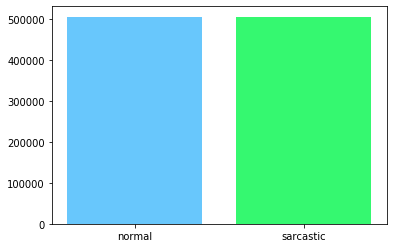

In [91]:
color_rectangle = np.random.rand(2, 3)
plt.bar([0,1], train_df['label'].value_counts().values, color=color_rectangle)
plt.xticks([0,1], ['normal', 'sarcastic']);

##### Distribution of lengths for sarcastic and normal comments is almost the same.

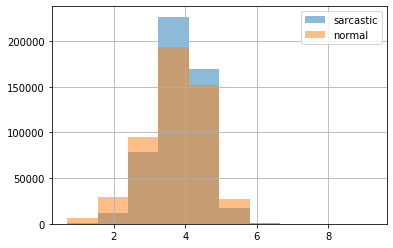

In [92]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

##### Let's see which subreddits are the most sarcastic ones

In [93]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


##### And the most sarcastic authors

In [94]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


##### Lets look at the most (frequent) "sarcastic" and "normal" words

In [95]:
def preprocessing(texts):
    return [re.sub(r"([^ \w])", r" \1 ", str.lower(text)) for text in texts]

def smart_tokenization(texts):
    return [x for text in texts for x in text.split() if x not in STOPWORDS]

In [98]:
sarcastic_tokens = smart_tokenization(preprocessing(train_df.loc[train_df['label'] == 1, 'comment'].values))
normal_tokens = smart_tokenization(preprocessing(train_df.loc[train_df['label'] == 0, 'comment'].values))

In [99]:
def build_freq_vocab(tokens):
    freq_dict = {}
    for token in tokens:
        if (len(token) > 1):
            try:
                freq_dict[token] += 1
            except:
                freq_dict[token] = 1
    return freq_dict

In [100]:
sarcastic_dict = build_freq_vocab(sarcastic_tokens)
normal_dict = build_freq_vocab(normal_tokens)

In [101]:
top_sarcastic = sorted(sarcastic_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_normal = sorted(normal_dict.items(), key=lambda x: x[1], reverse=True)[:10]

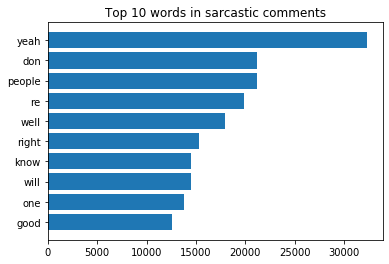

In [102]:
plt.barh([(10-i) for i in range(10)], [i[1] for i in top_sarcastic])
plt.yticks([(10-i) for i in range(10)], [i[0] for i in top_sarcastic]);
plt.title("Top 10 words in sarcastic comments");

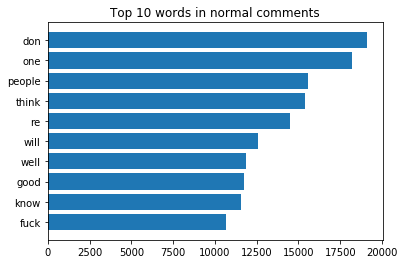

In [103]:
plt.barh([(10-i) for i in range(10)], [i[1] for i in top_normal])
plt.yticks([(10-i) for i in range(10)], [i[0] for i in top_normal]);
plt.title("Top 10 words in normal comments");

In [9]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'].values, train_df['label'].values, random_state=17)

# Models

In [10]:
def preprocessing(texts):
    return [re.sub(r"([^ \w])", r" \1 ", str.lower(text)) for text in texts]

def tokenization(texts):
    return [text.split() for text in texts]

def build_vocabulary(data):
    vocab = dict()
    for d in data:
        for w in d:
            try:
                vocab[w]
            except:
                vocab[w] = len(vocab)
    return vocab

def build_embeddings_glove(file_path, vocab, d=300):
    emb_dict = dict()
    unk_array = np.zeros(d)
    with open(file_path, 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                vocab[word]
                vector = np.asarray(values[1:], "float32")
                emb_dict[word] = vector
                unk_array += vector
            except:
                continue
    emb_dict['UNK'] = unk_array / len(emb_dict)
    return emb_dict

def build_w2v_dict(file_path, vocab, d=300):
    emb_dict = dict()
    unk_array = np.zeros(d)
    w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    for word in vocab.keys():
        try:
            vector = w2v_model.get_vector(word)
            emb_dict[word] = vector
            unk_array += vector
        except:
            continue
    emb_dict['UNK'] = unk_array / len(emb_dict)
    return emb_dict

def build_emb_matrix_lr(data, emb_dict):
    X = []
    cnt_unk = 0
    cnt_total = 0
    for d in data:
        sentence_emb = np.zeros(len(emb_dict['UNK']))
        for w in d:
            cnt_total += 1
            try:
                sentence_emb += emb_dict[w]
            except:
                cnt_unk += 1
                sentence_emb += emb_dict['UNK']
        X.append(sentence_emb / len(d))
    return np.array(X), cnt_unk / cnt_total

def build_emb_dict_nn(file_path, vocab, d=300):
    emb_dict = dict()
    unk_array = np.zeros(d)
    with open(file_path, 'r', encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                vocab[word]
                vector = np.asarray(values[1:], "float32")
                emb_dict[word] = vector
                unk_array += vector
            except:
                continue
    emb_dict['UNK'] = unk_array / len(emb_dict)
    emb_dict['PAD'] = np.zeros(d)
    return emb_dict

def build_emb_matrix_nn(file_path, vocab, d=300):
    emb_dict = build_emb_dict_nn(file_path, vocab, d=d)
    emb_matrix = np.zeros((len(emb_dict), d))
    word2idx = {'UNK': 0, 'PAD': 1}
    for word in sorted(list(set(emb_dict.keys()) - set(['UNK', 'PAD']))):
        word2idx[word] = len(word2idx)
    for w, i in word2idx.items():
        emb_matrix[i] = emb_dict[w]
    emb_matrix = torch.tensor(emb_matrix)
    return emb_matrix, word2idx

def build_w2v_dict_nn(file_path, vocab, d=300):
    emb_dict = dict()
    unk_array = np.zeros(d)
    w2v_model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    for word in vocab.keys():
        try:
            vector = w2v_model.get_vector(word)
            emb_dict[word] = vector
            unk_array += vector
        except:
            continue
    emb_dict['UNK'] = unk_array / len(emb_dict)
    emb_dict['PAD'] = np.zeros(d)
    return emb_dict

def build_emb_matrix_nn_w2v(file_path, vocab, d=300):
    emb_dict = build_w2v_dict_nn(file_path, vocab, d=d)
    emb_matrix = np.zeros((len(emb_dict), d))
    word2idx = {'UNK': 0, 'PAD': 1}
    for word in sorted(list(set(emb_dict.keys()) - set(['UNK', 'PAD']))):
        word2idx[word] = len(word2idx)
    for w, i in word2idx.items():
        emb_matrix[i] = emb_dict[w]
    emb_matrix = torch.tensor(emb_matrix)
    return emb_matrix, word2idx

class LR_Doc2Vec:
    def __init__(self, doc2vec_model, C=1.0):
        super(LR_Doc2Vec, self).__init__()
        self.doc2vec_model = doc2vec_model
        self.C = C
        self.lr = LogisticRegression(C=C, random_state=13)
    
    def load_embeddings(self, X):
        X_emb = []
        for x in X:
            X_emb.append(self.doc2vec_model.infer_vector(x))
        X_emb = np.array(X_emb)
        return X_emb

    def fit(self, X_train, y_train):
        X_train_emb = self.load_embeddings(X_train)
        self.lr.fit(X_train_emb, y_train)
        del X_train_emb
        return self
    
    def predict(self, X_test):
        X_test_emb = self.load_embeddings(X_test)
        y_pred = self.lr.predict(X_test_emb)
        del X_test_emb
        return y_pred
    
    def predict_proba(self, X_test):
        X_test_emb = self.load_embeddings(X_test)
        y_pred = self.lr.predict_proba(X_test_emb)
        del X_test_emb
        return y_pred

class BiLSTM(nn.Module):
    def __init__(self, emb_matrix, hidden_size=64, output_size=2, freeze_emb=True):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(emb_matrix)
        if freeze_emb:
            self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
            input_size=self.embedding.embedding_dim,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x_emb = self.embedding(x)
        # (batch, seq_len, num_directions * hidden_size)
        lstm_out, _ = self.lstm(x_emb.float())
        # (batch, seq_len, num_directions, hidden_size)
        lstm_out = lstm_out.view(lstm_out.shape[0], lstm_out.shape[1], -1, self.hidden_size)
        # lstm_out[:, :, 0, :] -- output of the forward LSTM
        # lstm_out[:, :, 1, :] -- output of the backward LSTM
        # we take the last hidden state of the forward LSTM and the first hidden state of the backward LSTM
        x_fc = torch.cat((lstm_out[:, -1, 0, :], lstm_out[:, 0, 1, :]), dim=1)
        fc_out = self.fc(x_fc)
        out = self.softmax(fc_out)
        return out

def as_matrix(documents, word2idx, max_len=None):
    max_doc_len = max(map(len, documents))
    if max_len is None:
        max_len = max_doc_len
    else:
        max_len = min(max_doc_len, max_len)
    matrix = np.ones((len(documents), max_len), dtype=np.int64)
    for i, doc in enumerate(documents):
        row_ix = [word2idx.get(word, 0) for word in doc[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    return matrix

def predict_bilstm(model, dev_data, word2idx, max_len=300, device=device, batch_size=16):
    with torch.no_grad():
        val_size = len(dev_data)
        y_pred = np.zeros(val_size, dtype=float)
        for i in range(0, val_size, batch_size):
            x = as_matrix(dev_data[i:(i + batch_size)], word2idx, max_len)
            x = torch.tensor(x).long()
            x = x.to(device)
            prediction = model(x)[:, 1]
            y_pred[i:(i + batch_size)] = prediction.cpu().detach().numpy()
    return y_pred

class BiLSTM_ELMo(nn.Module):
    def __init__(self, elmo, input_size=256, hidden_size=64, output_size=2):
        super(BiLSTM_ELMo, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = elmo
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x_emb = self.embedding(x)['elmo_representations'][0]
        # (batch, seq_len, num_directions * hidden_size)
        lstm_out, _ = self.lstm(x_emb.float())
        # (batch, seq_len, num_directions, hidden_size)
        lstm_out = lstm_out.view(lstm_out.shape[0], lstm_out.shape[1], -1, self.hidden_size)
        # lstm_out[:, :, 0, :] -- output of the forward LSTM
        # lstm_out[:, :, 1, :] -- output of the backward LSTM
        # we take the last hidden state of the forward LSTM and the first hidden state of the backward LSTM
        x_fc = torch.cat((lstm_out[:, -1, 0, :], lstm_out[:, 0, 1, :]), dim=1)
        fc_out = self.fc(x_fc)
        out = self.softmax(fc_out)
        return out

def predict_bilstm_elmo(model, dev_data, max_len=300, device=device, batch_size=4):
    with torch.no_grad():
        val_size = len(dev_data)
        y_pred = np.zeros(val_size, dtype=float)
        for i in range(0, val_size, batch_size):
            x = batch_to_ids(dev_data[i:(i + batch_size)])
            if max_len is not None:
                x = x[:, :max_len]
            x = x.to(device)
            prediction = model(x)[:, 1]
            y_pred[i:(i + batch_size)] = prediction.cpu().detach().numpy()
    return y_pred

def set_random_seeds(seed_value=13, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [11]:
%%time

train_tokens = tokenization(preprocessing(train_texts))
valid_tokens = tokenization(preprocessing(valid_texts))

vocab = build_vocabulary(train_tokens)
print("Vocabulary size:", len(vocab))

Vocabulary size: 143374
Wall time: 10.6 s


First of all, we tried Logistic Regression with various feature representations for texts. We tried to use it based on TF-IDF matrix, matrix of counts, word embeddings (GloVe and word2vec) and document embeddings (Doc2Vec).

### LR + TF-IDF

In [24]:
%%time

tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=5)
train_texts_tfidf = tfidf_vec.fit_transform(train_texts)
valid_texts_tfidf = tfidf_vec.transform(valid_texts)

Wall time: 1min 1s


In [25]:
%%time

lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=13)
lr.fit(train_texts_tfidf, y_train)
y_pred_lr_tfidf = lr.predict_proba(valid_texts_tfidf)[:, 1]
print(roc_auc_score(y_valid, y_pred_lr_tfidf))

0.7942782786624244
Wall time: 31.8 s


### LR + CountVectorizer

In [12]:
%%time

cnt_vec = CountVectorizer(ngram_range=(1, 3), max_features=40000, min_df=1)
train_texts_cnt = cnt_vec.fit_transform(train_texts)
valid_texts_cnt = cnt_vec.transform(valid_texts)

Wall time: 50.4 s


In [13]:
%%time

lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=13)
lr.fit(train_texts_cnt, y_train)
y_pred_lr_cnt = lr.predict_proba(valid_texts_cnt)[:, 1]
print(roc_auc_score(y_valid, y_pred_lr_cnt))

0.7877326249300394
Wall time: 55.2 s


### LR + GloVe

In [15]:
emb_dict = build_embeddings_glove('glove.6B.300d.txt', vocab)
print('Unique vectors in embeddings dictionary:', len(emb_dict))

train_emb_matrix, train_unk = build_emb_matrix_lr(train_tokens, emb_dict)
valid_emb_matrix, valid_unk = build_emb_matrix_lr(valid_tokens, emb_dict)
print('Train embedding matrix shape:', train_emb_matrix.shape)
print('Train: {:.2f}% unknown words'.format(train_unk * 100))
print('Valid embedding matrix shape:', valid_emb_matrix.shape)
print('Valid: {:.2f}% unknown words'.format(valid_unk * 100))

Unique vectors in embeddings dictionary: 78684
Train embedding matrix shape: (758079, 300)
Train: 1.34% unknown words
Valid embedding matrix shape: (252694, 300)
Valid: 1.59% unknown words


In [16]:
%%time

lr = LogisticRegression(C=5, solver='sag', max_iter=500, random_state=13)
lr.fit(train_emb_matrix, y_train)
y_pred_lr_glove = lr.predict_proba(valid_emb_matrix)[:, 1]
print(roc_auc_score(y_valid, y_pred_lr_glove))

0.6748553399754051
Wall time: 46.7 s


### LR + Word2Vec

In [17]:
emb_dict = build_w2v_dict('GoogleNews-vectors-negative300.bin', vocab)
print('Unique vectors in embeddings dictionary:', len(emb_dict))

train_emb_matrix, train_unk = build_emb_matrix_lr(train_tokens, emb_dict)
valid_emb_matrix, valid_unk = build_emb_matrix_lr(valid_tokens, emb_dict)
print('Train embedding matrix shape:', train_emb_matrix.shape)
print('Train: {:.2f}% unknown words'.format(train_unk * 100))
print('Valid embedding matrix shape:', valid_emb_matrix.shape)
print('Valid: {:.2f}% unknown words'.format(valid_unk * 100))

Unique vectors in embeddings dictionary: 62373
Train embedding matrix shape: (758079, 300)
Train: 23.67% unknown words
Valid embedding matrix shape: (252694, 300)
Valid: 23.71% unknown words


In [18]:
%%time

lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=13)
lr.fit(train_emb_matrix, y_train)
y_pred_lr_w2v = lr.predict_proba(valid_emb_matrix)[:, 1]
print(roc_auc_score(y_valid, y_pred_lr_w2v))

0.673213417887968
Wall time: 24.7 s


### LR + Doc2Vec

In [19]:
%%time

train_docs = [TaggedDocument(d, [i]) for (i, d) in enumerate(train_tokens)]
doc2vec_model = Doc2Vec(vector_size=300, min_count=1, epochs=5)
doc2vec_model.build_vocab(train_docs)
doc2vec_model.train(train_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Wall time: 3min 8s


In [20]:
%%time

lr_doc2vec = LR_Doc2Vec(doc2vec_model)
lr_doc2vec.fit(train_tokens, y_train)

Wall time: 3min 51s


In [21]:
%%time

y_pred_lr_doc2vec = lr_doc2vec.predict_proba(valid_tokens)[:, 1]
print(roc_auc_score(y_valid, y_pred_lr_doc2vec))

0.6774603171532291
Wall time: 49.2 s


Then we tried NN models. We used BiLSTM with GloVe, word2vec and ELMo embeddings.

### BiLSTM + GloVe

In [106]:
%%time

emb_matrix_bilstm_glove, word2idx_bilstm_glove = build_emb_matrix_nn('glove.6B.300d.txt', vocab)
print('Unique vectors in embedding matrix:', len(emb_matrix_bilstm_glove))

Unique vectors in embedding matrix: 78685
Wall time: 24.8 s


In [107]:
%%time

BILSTM_STATE_DICT = 'bilstm_glove.pt'
hidden_size = 128

bilstm_glove = BiLSTM(emb_matrix_bilstm_glove, hidden_size).to(device)
bilstm_glove.load_state_dict(torch.load(BILSTM_STATE_DICT, map_location=device))
bilstm_glove.eval()

y_pred_bilstm_glove = predict_bilstm(bilstm_glove, valid_tokens, word2idx_bilstm_glove)
print(roc_auc_score(y_valid, y_pred_bilstm_glove))

0.8097815263231354
Wall time: 44.5 s


### BiLSTM + Word2Vec

In [28]:
%%time

emb_matrix_bilstm_w2v, word2idx_bilstm_w2v = build_emb_matrix_nn_w2v('GoogleNews-vectors-negative300.bin', vocab)
print('Unique vectors in embedding matrix:', len(emb_matrix_bilstm_w2v))

Unique vectors in embedding matrix: 62374
Wall time: 1min 4s


In [29]:
%%time

BILSTM_STATE_DICT = 'bilstm_w2v.pt'
hidden_size = 128

bilstm_w2v = BiLSTM(emb_matrix_bilstm_w2v, hidden_size).to(device)
bilstm_w2v.load_state_dict(torch.load(BILSTM_STATE_DICT, map_location=device))
bilstm_w2v.eval()

y_pred_bilstm_w2v = predict_bilstm(bilstm_w2v, valid_tokens, word2idx_bilstm_w2v)
print(roc_auc_score(y_valid, y_pred_bilstm_w2v))

0.7942717703722182
Wall time: 33.4 s


### BiLSTM + ELMo

In [11]:
%%time

BILSTM_STATE_DICT = 'bilstm_elmo.pt'

hidden_size = 64

options_file = "elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 1, dropout=0)
bilstm_elmo = BiLSTM_ELMo(elmo, hidden_size=hidden_size).to(device)
bilstm_elmo.load_state_dict(torch.load(BILSTM_STATE_DICT, map_location=device))
bilstm_elmo.eval()

y_pred_bilstm_elmo = predict_bilstm_elmo(bilstm_elmo, valid_tokens, max_len=50, batch_size=256)
print(roc_auc_score(y_valid, y_pred_bilstm_elmo))

0.8089476675477861
Wall time: 17min 48s


# Results Analysis

BiLSTM model with GloVe embeddings showed the best results. Let's take a look at the ROC-curve.

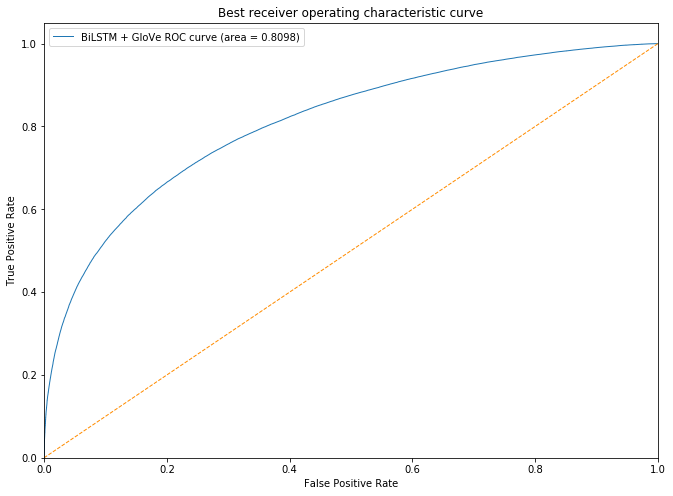

In [23]:
def generate_metrics(prediction, y_true):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_true, 1 - prediction)
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y_true, prediction)
    roc_auc[1] = auc(fpr[1], tpr[1])
    return fpr, tpr, roc_auc

bilstm_glove_fpr, bilstm_glove_tpr, bilstm_glove_roc_auc = generate_metrics(y_pred_bilstm_glove, y_valid)

plt.figure(figsize=(11, 8))
plt.plot(bilstm_glove_fpr[1], bilstm_glove_tpr[1], lw=1, label='BiLSTM + GloVe ROC curve (area = %0.4f)' % bilstm_glove_roc_auc[1])
plt.plot([0, 1], [0, 1], lw=1, color='darkorange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best receiver operating characteristic curve')
plt.legend(loc='best')
plt.show()

Transform probabilities to classes to plot confusion matrix and compute accuracy.

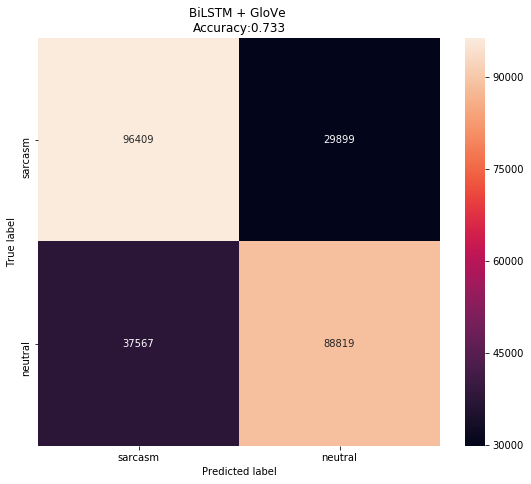

In [37]:
y_pred = (y_pred_bilstm_glove >= 0.5).astype(int)
cm = confusion_matrix(y_valid, y_pred)
cm_df = pd.DataFrame(cm, index=['sarcasm', 'neutral'], columns = ['sarcasm', 'neutral'])

plt.figure(figsize=(9, 7.5))
sns.heatmap(cm_df, fmt='d', annot=True)
plt.title('BiLSTM + GloVe \nAccuracy:{0:.3f}'.format(accuracy_score(y_valid, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we can see, model makes more mistakes in neutral class, more often considering it as sarcasm then considering sarcasm class neutral. Let's check where it makes worst mistakes.

In [84]:
def select_mistakes(y_true, y_pred_proba, texts, model_prediction, n=10):
    assert model_prediction in ['sarcasm', 'neutral']
    false_idx = np.where(y_true != (y_pred_proba >= 0.5).astype(int))
    mistakes_idx = y_pred_proba[false_idx].argsort()
    if model_prediction == 'sarcasm':
        mistakes_idx = mistakes_idx[::-1][:n]
    else:
        mistakes_idx = mistakes_idx[:n]
    mistakes = []
    for i in range(n):
        text = texts[false_idx][mistakes_idx[i]]
        model_pred = y_pred_proba[false_idx][mistakes_idx[i]]
        true_label = y_true[false_idx][mistakes_idx[i]]
        mistakes.append((text, model_pred, true_label))
    return mistakes

In [85]:
mistakes_sarcasm = select_mistakes(y_valid, y_pred_bilstm_glove, valid_texts, 'sarcasm')
for text, model_pred, true_label in mistakes_sarcasm:
    print('True label: {} | Model prediction: {:.4f}'.format(true_label, model_pred))
    print(text)

True label: 0 | Model prediction: 0.9987
Yeah, objective evidence refuting a belief is totally the same as a political ideology.
True label: 0 | Model prediction: 0.9982
Yeah, everyone insulting everyone for everything gives it an air of slight acceptance of everything.
True label: 0 | Model prediction: 0.9982
Because those poor black men are being oppressed!
True label: 0 | Model prediction: 0.9980
Oh ok, glad we cleared that up
True label: 0 | Model prediction: 0.9979
Yeah, sound quality is arguably the most important aspect of a piece of media.
True label: 0 | Model prediction: 0.9979
Oh yes, I'm sure women who have been raped will tell you the same thing.
True label: 0 | Model prediction: 0.9977
Yeah because we needed another rant video
True label: 0 | Model prediction: 0.9968
But unreliable gun has such better prices!
True label: 0 | Model prediction: 0.9967
Yeah, because we all know how well Kespa promotes their players' personality to foreign fans.
True label: 0 | Model predicti

Seems like the model overfits to the words "yeah" and "oh ok" in the beginning of the sentences.

In [86]:
mistakes_neutral = select_mistakes(y_valid, y_pred_bilstm_glove, valid_texts, 'neutral')
for text, model_pred, true_label in mistakes_neutral:
    print('True label: {} | Model prediction: {:.4f}'.format(true_label, model_pred))
    print(text)

True label: 1 | Model prediction: 0.0135
There actual field manuals for running an insurrection, iirc at one time the CIA had one, there was also a US army manual on something similar plus the usual suspects I'm not naming just on the off chance there is a list I'm not already on
True label: 1 | Model prediction: 0.0160
I didn't think this was necessary given the vein of the comment I was replying to, but:
True label: 1 | Model prediction: 0.0165
I want to upvote this because I like EXO, but I can't because I have no idea what is the reason of this performance and I feel uncomfortable watching this because of the weird shots here and there EDIT : And also I noticed Lay is missing ,ggwp EXO OT8 scandal inc
True label: 1 | Model prediction: 0.0186
From the number of times I have read about fines and settlements reached - monetary punitive measures really seem to be fucking working.
True label: 1 | Model prediction: 0.0191
You have indeed, and it's interesting as FUCK :) Sounded like it, 

The model mistakenly takes these sarcastic comments as neutral, but actually it is pretty hard to see sarcasm in some of them, so these are probably really hard cases.

Now let's select best model guesses.

In [87]:
def select_guesses(y_true, y_pred_proba, texts, model_prediction, n=10):
    assert model_prediction in ['sarcasm', 'neutral']
    correct_idx = np.where(y_true == (y_pred_proba >= 0.5).astype(int))
    guesses_idx = y_pred_proba[correct_idx].argsort()
    if model_prediction == 'sarcasm':
        guesses_idx = guesses_idx[::-1][:n]
    else:
        guesses_idx = guesses_idx[:n]
    guesses = []
    for i in range(n):
        text = texts[correct_idx][guesses_idx[i]]
        model_pred = y_pred_proba[correct_idx][guesses_idx[i]]
        true_label = y_true[correct_idx][guesses_idx[i]]
        guesses.append((text, model_pred, true_label))
    return guesses

In [88]:
guesses_sarcasm = select_guesses(y_valid, y_pred_bilstm_glove, valid_texts, 'sarcasm')
for text, model_pred, true_label in guesses_sarcasm:
    print('True label: {} | Model prediction: {:.4f}'.format(true_label, model_pred))
    print(text)

True label: 1 | Model prediction: 0.9996
yeah, because filibusters are totally a recent invention
True label: 1 | Model prediction: 0.9996
Yeah, because that is so constructive and totally not falling to her level.
True label: 1 | Model prediction: 0.9996
Yes, because we totally need another MOBA
True label: 1 | Model prediction: 0.9996
Yeah, clearly that developer knew nothing about computers and only uses Facebook
True label: 1 | Model prediction: 0.9995
Yeah, clearly everyone should use 3200DPI with a tiny mousepad
True label: 1 | Model prediction: 0.9995
Yeah, we totally see mass shootings every day over here in europe
True label: 1 | Model prediction: 0.9995
Yep, because Asian women are totally incapable of giving consent
True label: 1 | Model prediction: 0.9995
Yeah, it's totally illuminating and welcoming to a multitude of world views.
True label: 1 | Model prediction: 0.9995
Yeah totally seems like a reliable source
True label: 1 | Model prediction: 0.9995
Yeah, because women c

Wow, ten out of ten most correctly identified sarcastic comments start with the words "yeah", "yes" or "yep"!

In [89]:
guesses_neutral = select_guesses(y_valid, y_pred_bilstm_glove, valid_texts, 'neutral')
for text, model_pred, true_label in guesses_neutral:
    print('True label: {} | Model prediction: {:.4f}'.format(true_label, model_pred))
    print(text)

True label: 0 | Model prediction: 0.0061
I did the same but i lost the button i removed so there goes any chance of trading it in for a slim :/ Sometimes i get lazy and have a straightened paper clip and push it through the hole bellow where the eject button used to be and you can press the contact in there to eject it.
True label: 0 | Model prediction: 0.0066
Fair enough but still for me it directly comes out of his hands propelled forwards, what you say is true with the forward momentum in most cases but not this one.
True label: 0 | Model prediction: 0.0072
I tried it a few weeks ago, it just didn't seem to do too much for me, it was pretty bland IMO, i was sad :/
True label: 0 | Model prediction: 0.0073
I've usually been inside, but found that temp has still been negative inside... I'm not home right now but when I get home I can check, it might just have been me misreading the temperature :P
True label: 0 | Model prediction: 0.0077
I honestly didn't check to see the costs of highe

Nice, clearly these are neutral comments.

# Model interpretation

In order to make more clear model interpretation, we used [LIME](https://arxiv.org/abs/1602.04938).

In [113]:
def predict_for_lime(list_texts):
    x = tokenization(preprocessing(list_texts))
    y_pred = predict_bilstm(bilstm_glove, x, word2idx_bilstm_glove)
    return np.stack([1 - y_pred, y_pred], axis=1)

Let's see what triggers model on the example with the highest mistake.

Yeah, objective evidence refuting a belief is totally the same as a political ideology.

Sarcasm: 0.9964801669120789


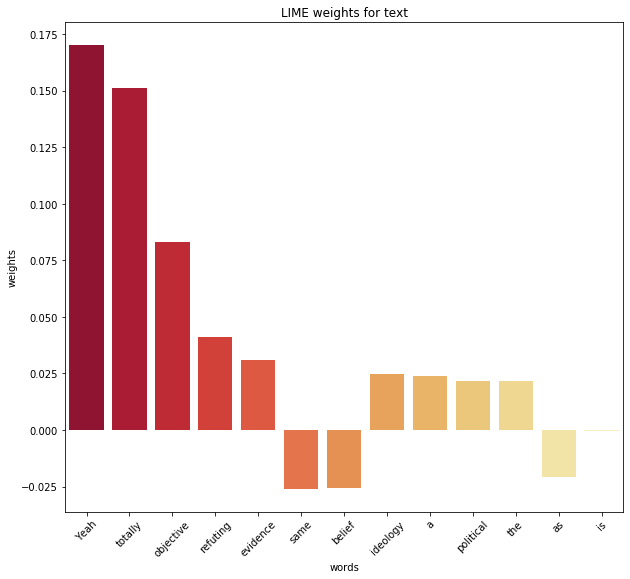

In [115]:
text = mistakes_sarcasm[0][0]
explainer = LimeTextExplainer()
explanation = explainer.explain_instance(text, predict_for_lime, num_features=20)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})
print(text)
print()
print('Sarcasm:', predict_bilstm(bilstm_glove, tokenization(preprocessing([text])), word2idx_bilstm_glove)[0])

plt.figure(figsize=(10, 9))
sns.barplot(x="words", y="weights", data=lime_weights, palette='YlOrRd_r');
plt.xticks(rotation=45)
plt.title('LIME weights for text'.format(0))
plt.show()

It reacts too much to the words "yeah" and "totally". Actually, from a human point of view, these are really hard trigger words, but according to the sentence it seems like they really are used in a neutral context. So the model is really tricked here.

There actual field manuals for running an insurrection, iirc at one time the CIA had one, there was also a US army manual on something similar plus the usual suspects I'm not naming just on the off chance there is a list I'm not already on

Sarcasm: 0.013517528772354126


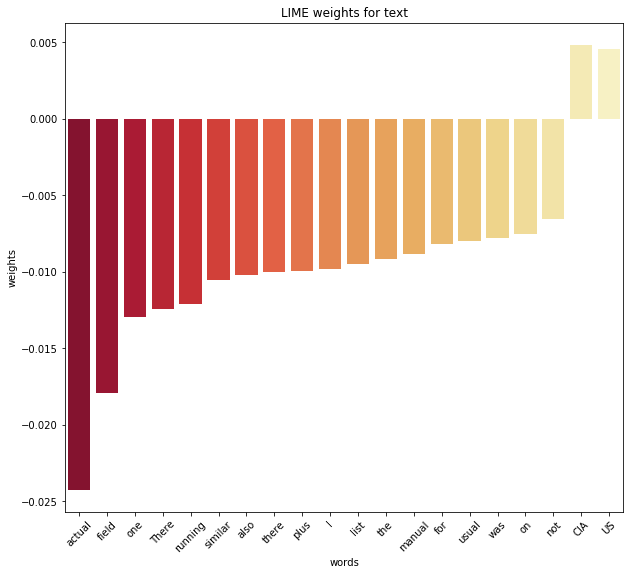

In [116]:
text = mistakes_neutral[0][0]
explainer = LimeTextExplainer()
explanation = explainer.explain_instance(text, predict_for_lime, num_features=20)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})
print(text)
print()
print('Sarcasm:', predict_bilstm(bilstm_glove, tokenization(preprocessing([text])), word2idx_bilstm_glove)[0])

plt.figure(figsize=(10, 9))
sns.barplot(x="words", y="weights", data=lime_weights, palette='YlOrRd_r');
plt.xticks(rotation=45)
plt.title('LIME weights for text'.format(0))
plt.show()

Absolutely no triggers => model thinks this is a neutral case.

In [131]:
%%time

n = 500

np.random.seed(13)
valid_global = np.random.choice(valid_texts, size=n)

lime_weights = {}
for i in range(n):
    text = valid_global[i]
    if (len(text.split()) > 1):
        explanation = explainer.explain_instance(text, predict_for_lime, num_features=20)
        weights = OrderedDict(explanation.as_list())
        for key in weights.keys():
            try:
                lime_weights[key] += weights[key]
            except:
                lime_weights[key] = weights[key]

print()


Wall time: 11min 46s


In [133]:
df_weights = pd.DataFrame({'words': list(lime_weights.keys()), 'weights': list(lime_weights.values())})
df_weights['weights_scaled'] = df_weights['weights'] / abs(df_weights['weights']).sum()
df_weights_scaled = df_weights[['words', 'weights_scaled']]

w_neg = df_weights_scaled.sort_values(by=['weights_scaled'], ascending=True)[:20]
w_pos = df_weights_scaled.sort_values(by=['weights_scaled'], ascending=False)[:20]

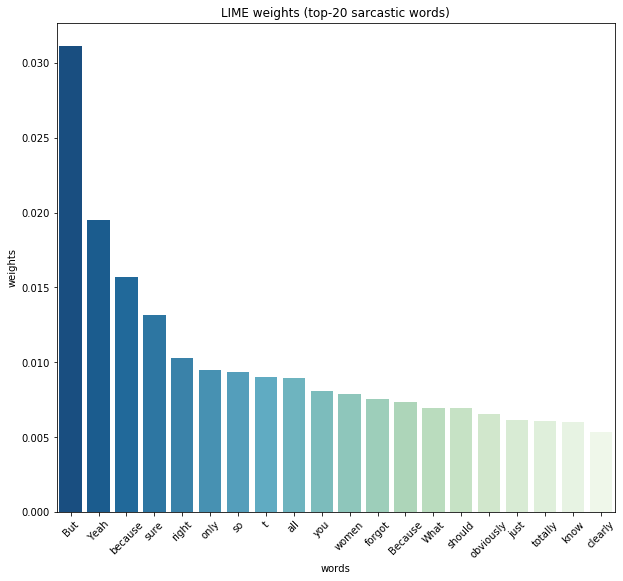

In [134]:
plt.figure(figsize=(10, 9))
sns.barplot(x="words", y="weights_scaled", data=w_pos, palette='GnBu_r');
plt.xticks(rotation=45)
plt.title('LIME weights (top-20 sarcastic words)'.format(0))
plt.ylabel('weights')
plt.show()

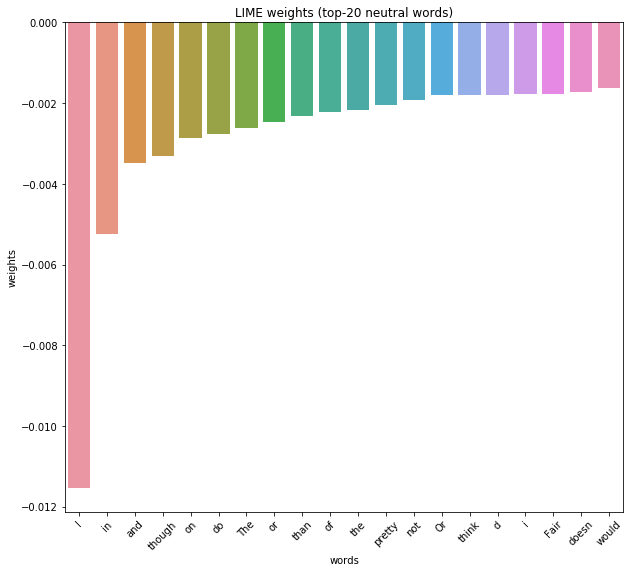

In [135]:
plt.figure(figsize=(10, 9))
sns.barplot(x="words", y="weights_scaled", data=w_neg);
plt.xticks(rotation=45)
plt.title('LIME weights (top-20 neutral words)'.format(0))
plt.ylabel('weights')
plt.show()

We can see that the results are pretty interpretable. Neutral words are really neutral. An interesting result is that a word "I" is the most neutral - probably because if people use "I", they naturally express their own opinion, and this imply a serious comment (non-sarcasm). Many sarcastic words are really used in sarcastic contexts: "Yeah", "sure", "right", "only".

So, we achieved a quality of approximately 0.8 AUC-ROC. It seems pretty OK, but it shows that the task is really tough which is seen from the interpreted examples (where there seems to be absolutely no sarcastic words, but there is a sarcasm). So the models might be more complex to understand sarcasm, but from the tested options BiLSTM + GloVe embeddings were the best.

According to the analysis of the results, the sarcasm mainly can be identified by trigger (sarcastic) words. This seems applicable to the real life - there, sarcastic words also can often show that the whole phrase is sarcastic.